In [1]:
import numpy as np
import pandas as pd
import pertpy
import scanpy as sc
from rdkit import Chem

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

In [2]:
print(pertpy.__version__)

0.7.0


In [3]:
df_cell_line = pd.read_csv(
    "/lustre/groups/ml01/workspace/alejandro.tejada/super_rad_project/cell_line_embeddings/cell_line_embedding_full_ccle_300.csv"
)

In [4]:
df_cell_line

,stripped_cell_line_name,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,LC1SQSF,-18.392076,-4.417238,-20.063112,11.465690,-13.339292,-12.112496,35.471240,-0.270913,-9.146312,...,-1.125420,-2.111881,1.171622,0.312624,-4.815182,0.046210,-1.088446,1.115714,2.255941,0.758469
1,COGAR359,18.690002,-52.472620,-30.365618,48.330795,-1.021920,-19.068594,10.263748,18.269790,-7.957102,...,-8.222550,7.555310,-1.057298,-3.757104,-4.835751,2.893510,-2.442304,-0.242649,-2.353538,5.478947
2,COLO794,-20.296114,-40.405025,44.187954,14.443377,54.673800,19.321410,66.251015,17.002750,-7.278839,...,-1.242781,1.199354,0.235240,-2.573665,-0.173201,1.236485,0.292051,3.587131,0.715897,-2.135028
3,KKU213,-27.366976,65.398420,14.705721,-7.561102,-13.943193,-10.408412,36.653570,25.901730,-14.653162,...,1.666245,-1.350878,2.853838,-1.963892,-6.147074,1.655094,4.646910,-0.388469,-3.185148,-0.161350
4,RT4,-12.577552,53.457300,-30.118093,-8.491399,-0.911463,-0.323962,12.441322,2.255388,-20.927351,...,-0.842232,3.961688,-1.545963,-3.391504,-1.337374,0.594023,5.249398,-6.942966,0.880904,0.362034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,TOLEDO,116.668144,-17.291414,-8.687904,-47.281456,-8.376022,-19.178888,14.364631,23.961452,1.910983,...,2.444952,0.755310,0.995932,-0.341458,-1.487758,-5.967835,-0.450100,-4.981550,-3.410032,1.127219
1402,KP363T,-13.191258,56.058205,18.988297,9.880114,10.289624,-20.659739,7.638542,36.926937,-4.758129,...,-0.800371,-1.895617,-5.030682,-0.387408,1.123831,1.471802,-3.277741,-0.741038,-3.711716,6.372540
1403,SSP25,-58.022533,-6.140889,37.952465,-7.738521,-9.254046,-8.542123,1.232968,23.845469,4.071693,...,-1.679806,-2.305954,-1.516615,0.437813,-0.213782,2.173585,-3.377421,-1.699599,-0.910430,-3.234072
1404,ECC2,-33.736560,68.016460,0.001811,-11.769738,2.804548,0.707982,3.129512,26.379341,-0.923006,...,-0.507274,-4.123481,0.603723,-2.813056,1.446870,-1.526545,-1.199487,3.615918,0.856891,-0.973312


In [5]:
mcf7_emb = df_cell_line[df_cell_line["stripped_cell_line_name"] == "MCF7"].iloc[0, 1:].values
k562_emb = df_cell_line[df_cell_line["stripped_cell_line_name"] == "K562"].iloc[0, 1:].values
a549_emb = df_cell_line[df_cell_line["stripped_cell_line_name"] == "A549"].iloc[0, 1:].values

In [6]:
adata = pertpy.data.sciplex3_raw()

In [7]:
bdata = pertpy.data.combosciplex()

In [8]:
len(set(adata.var_names).intersection(bdata.var_names)), adata.n_vars, bdata.n_vars

(27518, 58347, 27518)

In [9]:
adata = adata[:, bdata.var_names]

In [10]:
adata.n_vars

27518

In [11]:
adata.obs["cell_type"].value_counts()

cell_type
MCF7    292010
K562    146752
A549    143015
Name: count, dtype: int64

In [12]:
adata.obs["perturbation"] = adata.obs["product_name"]
adata.obs["drug"] = adata.obs.apply(lambda x: x["product_name"].replace(" ", "_"), axis=1)
adata.obs["cell_line"] = adata.obs["cell_type"]
adata.obs["logdose"] = adata.obs.apply(lambda x: np.log10(x["dose"]) if x["dose"] > 0.0 else 0.0, axis=1)
adata.obs.loc[:, "condition"] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.drug, str(x.dose)]), axis=1)

/tmp/ipykernel_1251955/4200154280.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["perturbation"] = adata.obs["product_name"]


In [13]:
def get_cell_line_embedding(x):
    if x["cell_line"] == "MCF7":
        return mcf7_emb.astype("float")[None, :]
    elif x["cell_line"] == "A549":
        return a549_emb.astype("float")[None, :]
    elif x["cell_line"] == "K562":
        return k562_emb.astype("float")[None, :]


adata.obsm["cell_line_emb"] = np.concatenate(adata.obs.apply(get_cell_line_embedding, axis=1).values, axis=0)

In [15]:
bdata.obs["cell_line"] = bdata.obs["cell_type"]

In [16]:
bdata.obsm["cell_line_emb"] = np.concatenate(bdata.obs.apply(get_cell_line_embedding, axis=1).values, axis=0)

In [17]:
conditions_to_keep = adata.obs.groupby("condition").apply(lambda x: len(x) >= 200)

/tmp/ipykernel_1251955/2482095754.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conditions_to_keep = adata.obs.groupby("condition").apply(lambda x: len(x) >= 200)


In [18]:
conds_to_keep = list(conditions_to_keep[conditions_to_keep == True].index)

In [19]:
adata = adata[adata.obs["condition"].isin(conds_to_keep)]

In [20]:
adata.n_obs

466557

In [21]:
conditions_to_keep = bdata.obs.groupby("condition").apply(lambda x: len(x) >= 200)

/tmp/ipykernel_1251955/846791439.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conditions_to_keep = bdata.obs.groupby("condition").apply(lambda x: len(x) >= 200)
/tmp/ipykernel_1251955/846791439.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conditions_to_keep = bdata.obs.groupby("condition").apply(lambda x: len(x) >= 200)


In [22]:
conds_to_keep = list(conditions_to_keep[conditions_to_keep == True].index)

In [23]:
bdata = bdata[bdata.obs["condition"].isin(conds_to_keep)]

In [24]:
bdata.n_obs

63378

In [25]:
adata_concat = adata.concatenate(bdata, join="outer")

/tmp/ipykernel_1251955/351737849.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata.concatenate(bdata, join="outer")


In [26]:
adata_concat

AnnData object with n_obs × n_vars = 529935 × 27518
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'perturbation', 'drug', 'cell_line', 'logdose', 'condition', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'pathway1', 'pathway2', 'split', 'control', 'batch'
    var: 'id-0', 'num_cells_expressed-0-0-0', 'num_cells_expressed-1-0-0', 'num_cells_expressed-1-0', 'id-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'cell_line_emb', 'X_pca', 'X_umap'
    layers: 'counts'

In [27]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [29]:
adata = adata[:, adata.var["highly_variable"] == True]

In [30]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


In [31]:
sc.tl.umap(adata)

In [2]:
adata.obs

NameError: name 'adata' is not defined

KeyError: 'Could not find key batch in .var_names or .obs.columns.'

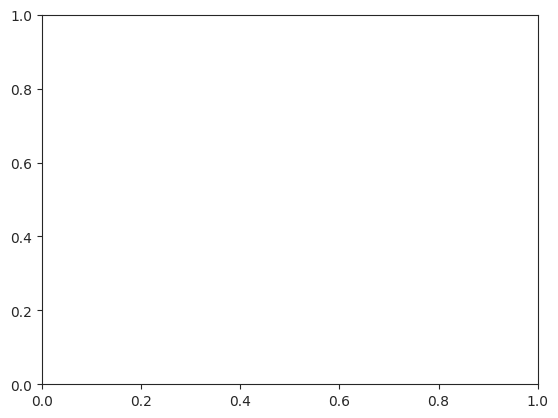

In [32]:
sc.pl.umap(adata, color="batch")

In [17]:
adata = adata[~adata.obs["drug"].isnull()]

In [18]:
pertpy.md.Compound().annotate_compounds(adata)

[bold blue]There are 187 identifiers in `adata.obs`.However, 6 identifiers can't be found in the compound annotation,leading to the presence of NA values for their respective metadata.

- Please check again: 
- Vehicle
- MC1568
- Bisindolylmaleimide IX (Ro 31-8220 Mesylate)
- Glesatinib?(MGCD265)
- Dacinostat (LAQ824)
- ...


AnnData object with n_obs × n_vars = 466557 × 2002
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'perturbation', 'drug', 'cell_line', 'logdose', 'condition', 'pubchem_name', 'pubchem_ID', 'smiles'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'cell_line_emb'

In [19]:
# taken from pubchem
smiles_dict = {
    "Dacinostat (LAQ824)": "C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=C/C(=O)NO",
    "Glesatinib?(MGCD265)": "COCCNCC1=CN=C(C=C1)C2=CC3=NC=CC(=C3S2)OC4=C(C=C(C=C4)NC(=S)NC(=O)CC5=CC=C(C=C5)F)F",
    "MC1568": "CN1C=C(C=C1/C=C/C(=O)NO)/C=C/C(=O)C2=CC(=CC=C2)F",
    "Ivosidenib (AG-120)": "C1CC(=O)N([C@@H]1C(=O)N(C2=CC(=CN=C2)F)[C@@H](C3=CC=CC=C3Cl)C(=O)NC4CC(C4)(F)F)C5=NC=CC(=C5)C#N",
    "Bisindolylmaleimide IX (Ro 31-8220 Mesylate)": "CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CN(C5=CC=CC=C54)CCCSC(=N)N",
}

In [20]:
adata.obs["smiles"].value_counts(dropna=False)

smiles
NaN                                                                     23694
C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3                             5429
COC1=CC=CC(=C1N)C2=CC(=O)C3=CC=CC=C3O2                                   3763
CC(C1=CC=CC=C1)NC(=O)C(=CC2=NC(=CC=C2)Br)C#N                             3722
COC1=C(C=CC(=C1)C=CC(=O)CC(=O)C=CC2=CC(=C(C=C2)O)OC)O                    3698
                                                                        ...  
CC1=CC(=NN1)NC2=CC(=NC(=N2)SC3=CC=C(C=C3)NC(=O)C4CC4)N5CCN(CC5)C          694
C1=CC=C(C(=C1)N)NC(=O)C2=CC=C(C=C2)CNC3=NC=CC(=N3)C4=CN=CC=C4             608
C1CC1NC(=O)NC2=C(NN=C2)C3=NC4=C(N3)C=C(C=C4)CN5CCOCC5                     594
CC1CCCC2(C(O2)CC(OC(=O)CC(C(C(=O)C(C1O)C)(C)C)O)C(=CC3=CSC(=N3)C)C)C      408
CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC=C4Cl)O)O.Cl                261
Name: count, Length: 181, dtype: int64

In [21]:
adata.obs["smiles"] = adata.obs[["smiles", "perturbation"]].apply(
    lambda x: smiles_dict[x["perturbation"]] if x["perturbation"] in smiles_dict.keys() else x["smiles"], axis=1
)

In [22]:
adata.obs["smiles"].value_counts(dropna=False)

smiles
NaN                                                                     13004
C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3                             5429
COC1=CC=CC(=C1N)C2=CC(=O)C3=CC=CC=C3O2                                   3763
CC(C1=CC=CC=C1)NC(=O)C(=CC2=NC(=CC=C2)Br)C#N                             3722
COC1=C(C=CC(=C1)C=CC(=O)CC(=O)C=CC2=CC(=C(C=C2)O)OC)O                    3698
                                                                        ...  
CC1=CC(=NN1)NC2=CC(=NC(=N2)SC3=CC=C(C=C3)NC(=O)C4CC4)N5CCN(CC5)C          694
C1=CC=C(C(=C1)N)NC(=O)C2=CC=C(C=C2)CNC3=NC=CC(=N3)C4=CN=CC=C4             608
C1CC1NC(=O)NC2=C(NN=C2)C3=NC4=C(N3)C=C(C=C4)CN5CCOCC5                     594
CC1CCCC2(C(O2)CC(OC(=O)CC(C(C(=O)C(C1O)C)(C)C)O)C(=CC3=CSC(=N3)C)C)C      408
CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC=C4Cl)O)O.Cl                261
Name: count, Length: 186, dtype: int64

In [23]:
adata[adata.obs["smiles"].isnull()].obs.dose.value_counts()

dose
0.0    13004
Name: count, dtype: int64

In [24]:
adata[~adata.obs["smiles"].isnull()].obs.dose.value_counts()

dose
10.0       130398
100.0      120764
1000.0     111644
10000.0     90747
Name: count, dtype: int64

In [25]:
from rdkit.Chem import AllChem


def get_fp(smiles, radius=4, nBits=1024):
    m = Chem.MolFromSmiles(smiles, sanitize=False)
    if m is None:
        return "invalid"
    else:
        try:
            Chem.SanitizeMol(m)
        except:
            return "invalid"
    return AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits)

In [26]:
smiles_to_fp = {}
for sm in adata.obs["smiles"].unique():
    if not isinstance(sm, str):
        continue
    smiles_to_fp[sm] = np.array(list(get_fp(sm)))

In [27]:
features_df = pd.DataFrame.from_dict(smiles_to_fp).T

In [28]:
features_cells = np.zeros((adata.shape[0], features_df.shape[1]))
for mol, ecfp in features_df.iterrows():
    features_cells[adata.obs["smiles"].isin([mol])] = ecfp.values

In [29]:
adata.obsm["ecfp"] = features_cells

In [30]:
def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    n_genes=50,
    rankby_abs=True,
    key_added="rank_genes_groups_cov",
    return_dict=False,
):
    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        # name of the control group in the groupby obs column
        control_group_cov = "_".join([cov_cat, "Vehicle", "0.0"])
        adata_cov = adata[adata.obs[covariate] == cov_cat]

        # compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes,
            use_raw=False,
        )
        # add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()
    adata.uns[key_added] = gene_dict
    if return_dict:
        return gene_dict


def get_DE_genes(adata):
    adata.obs.loc[:, "control"] = adata.obs.perturbation.apply(lambda x: 1 if x == "Vehicle" else 0)
    adata.obs = adata.obs.astype("category")
    rank_genes_groups_by_cov(
        adata,
        groupby="condition",
        covariate="cell_type",
        control_group="Vehicle",
        n_genes=50,
        key_added="rank_genes_groups_cov_all",
    )
    return adata

In [31]:
for col in adata.obs.select_dtypes(include=["category"]):
    adata.obs[col].cat.remove_unused_categories()

In [32]:
adata = get_DE_genes(adata)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [33]:
ood_drugs = [
    "Dacinostat",
    "Givinostat",
    "Belinostat",
    "Hesperadin",
    "Quisinostat",
    "Alvespimycin",
    "Tanespimycin",
    "TAK-901",
    "Flavopiridol",
]

In [34]:
[d for d in ood_drugs if d in adata.obs["drug"].unique()]

['Hesperadin', 'TAK-901']

In [35]:
[el for el in adata.obs["drug"].unique() if "acinostat" in el]

['Dacinostat_(LAQ824)', 'Pracinostat_(SB939)']

In [36]:
[el for el in adata.obs["drug"].unique() if "ivinostat" in el]

['Givinostat_(ITF2357)']

In [37]:
[el for el in adata.obs["drug"].unique() if "elinostat" in el]

['Belinostat_(PXD101)']

In [38]:
[el for el in adata.obs["drug"].unique() if "Quisinostat" in el]

['Quisinostat_(JNJ-26481585)_2HCl']

In [39]:
[el for el in adata.obs["drug"].unique() if "Alvespimycin" in el]

['Alvespimycin_(17-DMAG)_HCl']

In [40]:
[el for el in adata.obs["drug"].unique() if "Tanespimycin" in el]

['Tanespimycin_(17-AAG)']

In [41]:
[el for el in adata.obs["drug"].unique() if "Flavopiridol" in el]

['Flavopiridol_HCl']

In [42]:
ood_drugs = [
    "Hesperadin",
    "TAK-901",
    "Dacinostat_(LAQ824)",
    "Givinostat_(ITF2357)",
    "Belinostat_(PXD101)",
    "Quisinostat_(JNJ-26481585)_2HCl",
    "Alvespimycin_(17-DMAG)_HCl",
    "Tanespimycin_(17-AAG)",
    "Flavopiridol_HCl",
]

In [43]:
len(ood_drugs)

9

In [44]:
adata.obs["ood"] = adata.obs.apply(lambda x: x["drug"] if x["drug"] in ood_drugs else "not ood", axis=1)
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["drug"] in ood_drugs, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

In [45]:
adata_ood = adata[adata.obs["is_ood"]]

In [46]:
adata_train = adata[~adata.obs["is_ood"]]

In [47]:
rng = np.random.default_rng(0)
split_dfs = []
for cond in adata_train.obs["condition"].unique():
    adata_subset = adata_train[(adata_train.obs["condition"] == cond)]
    n_cells = adata_subset.n_obs
    if "Vehicle" in cond:
        idx_test = rng.choice(np.arange(n_cells), 500, replace=False)
        remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["condition"]].copy()
        df["split"] = split
        split_dfs.append(df)
    else:
        idx_test = rng.choice(np.arange(n_cells), 100, replace=False)
        split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
        df = adata_subset.obs[["condition"]].copy()
        df["split"] = split
        split_dfs.append(df)

In [48]:
df_concat = pd.concat(split_dfs, axis=0)

In [49]:
len(df_concat), adata_train.n_obs

(454740, 454740)

In [50]:
adata_train.obs["split"] = df_concat[["split"]]

/tmp/ipykernel_2788299/312432471.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs["split"] = df_concat[["split"]]


In [51]:
adata_ood[adata_ood.obs["condition"] == "control"].n_obs

0

In [52]:
adata_ood.obs["split"] = "ood"

/tmp/ipykernel_2788299/1413720144.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood.obs["split"] = "ood"


In [53]:
import anndata

adata_train_final = adata_train[adata_train.obs["split"] == "train"]
adata_test_final = adata_train[adata_train.obs["split"] == "test"]
adata_ood_final = anndata.concat((adata_ood, adata_test_final[adata_test_final.obs["perturbation"] == "Vehicle"]))

In [54]:
adata_train_final.obs["condition"].value_counts()

condition
MCF7_Vehicle_0.0                        5858
K562_Vehicle_0.0                        2859
A549_Vehicle_0.0                        2787
MCF7_Mesna__100.0                        607
MCF7_Fasudil_(HA-1077)_HCl_10000.0       493
                                        ... 
A549_Avagacestat_(BMS-708163)_10.0       100
A549_AR-42_10.0                          100
K562_AG-14361_1000.0                     100
A549_EED226_1000.0                       100
A549_AG-490_(Tyrphostin_B42)_10000.0     100
Name: count, Length: 1440, dtype: int64

In [55]:
adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T

/tmp/ipykernel_2788299/2775379558.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_train_final.varm["X_train_mean"] = adata_train_final.X.mean(axis=0).T


In [56]:
from scipy.sparse import csr_matrix

train_mean = adata_train_final.varm["X_train_mean"].T
adata_train_final.layers["centered_X"] = csr_matrix(adata_train_final.X.A - train_mean)

In [57]:
adata_train_final.layers["X_log1p"] = adata_train_final.X.copy()
adata_train_final.X = adata_train_final.layers["centered_X"]

In [58]:
sc.pp.pca(adata_train_final, zero_center=False, n_comps=300)

In [59]:
adata_train_final.X = adata_train_final.layers["X_log1p"]

In [60]:
adata_ood_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]
adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]

/tmp/ipykernel_2788299/3355210628.py:2: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_test_final.varm["X_train_mean"] = adata_train_final.varm["X_train_mean"]


In [61]:
adata_test_final.layers["centered_X"] = csr_matrix(adata_test_final.X.A - train_mean)
adata_ood_final.layers["centered_X"] = csr_matrix(adata_ood_final.X.A - train_mean)

In [62]:
adata_test_final.obsm["X_pca"] = np.matmul(adata_test_final.layers["centered_X"].A, adata_train_final.varm["PCs"])
adata_ood_final.obsm["X_pca"] = np.matmul(adata_ood_final.layers["centered_X"].A, adata_train_final.varm["PCs"])

In [63]:
adata_train_final.obs["logdose"] = adata_train_final.obs.apply(
    lambda x: np.log10(x["dose"]) if x["dose"] > 0.0 else 0.0, axis=1
)

In [64]:
adata_train_final.obsm["ecfp_cell_line"] = np.concatenate(
    (adata_train_final.obsm["ecfp"], adata_train_final.obsm["cell_line_emb"]), axis=1
)
adata_test_final.obsm["ecfp_cell_line"] = np.concatenate(
    (adata_test_final.obsm["ecfp"], adata_test_final.obsm["cell_line_emb"]), axis=1
)
adata_ood_final.obsm["ecfp_cell_line"] = np.concatenate(
    (adata_ood_final.obsm["ecfp"], adata_ood_final.obsm["cell_line_emb"]), axis=1
)

In [65]:
adata_train_final.obsm["ecfp_cell_line_dose"] = np.concatenate(
    (adata_train_final.obsm["ecfp_cell_line"], adata_train_final.obs["dose"].values[:, None]), axis=1
)
adata_test_final.obsm["ecfp_cell_line_dose"] = np.concatenate(
    (adata_test_final.obsm["ecfp_cell_line"], adata_test_final.obs["dose"].values[:, None]), axis=1
)
adata_ood_final.obsm["ecfp_cell_line_dose"] = np.concatenate(
    (adata_ood_final.obsm["ecfp_cell_line"], adata_ood_final.obs["dose"].values[:, None]), axis=1
)

In [66]:
adata_train_final.obsm["ecfp_cell_line_logdose"] = np.concatenate(
    (adata_train_final.obsm["ecfp_cell_line"], adata_train_final.obs["logdose"].values[:, None]), axis=1
)
adata_test_final.obsm["ecfp_cell_line_logdose"] = np.concatenate(
    (adata_test_final.obsm["ecfp_cell_line"], adata_test_final.obs["logdose"].values[:, None]), axis=1
)
adata_ood_final.obsm["ecfp_cell_line_logdose"] = np.concatenate(
    (adata_ood_final.obsm["ecfp_cell_line"], adata_ood_final.obs["logdose"].values[:, None]), axis=1
)

In [67]:
adata_train_final.obsm["ecfp_cell_line_logdose_more_dose"] = np.concatenate(
    (adata_train_final.obsm["ecfp_cell_line"], np.tile(adata_train_final.obs["logdose"].values[:, None], (1, 100))),
    axis=1,
)
adata_test_final.obsm["ecfp_cell_line_logdose_more_dose"] = np.concatenate(
    (adata_test_final.obsm["ecfp_cell_line"], np.tile(adata_test_final.obs["logdose"].values[:, None], (1, 100))),
    axis=1,
)
adata_ood_final.obsm["ecfp_cell_line_logdose_more_dose"] = np.concatenate(
    (adata_ood_final.obsm["ecfp_cell_line"], np.tile(adata_ood_final.obs["logdose"].values[:, None], (1, 100))), axis=1
)

In [68]:
adata_train_final.obsm["ecfp_cell_line_dose_more_dose"] = np.concatenate(
    (adata_train_final.obsm["ecfp_cell_line"], np.tile(adata_train_final.obs["dose"].values[:, None], (1, 100))), axis=1
)
adata_test_final.obsm["ecfp_cell_line_dose_more_dose"] = np.concatenate(
    (adata_test_final.obsm["ecfp_cell_line"], np.tile(adata_test_final.obs["dose"].values[:, None], (1, 100))), axis=1
)
adata_ood_final.obsm["ecfp_cell_line_dose_more_dose"] = np.concatenate(
    (adata_ood_final.obsm["ecfp_cell_line"], np.tile(adata_ood_final.obs["dose"].values[:, None], (1, 100))), axis=1
)

In [69]:
adata_train_final.varm["X_train_mean"] = np.asarray(adata_train_final.varm["X_train_mean"])
adata_test_final.varm["X_train_mean"] = np.asarray(adata_test_final.varm["X_train_mean"])
adata_ood_final.varm["X_train_mean"] = np.asarray(adata_ood_final.varm["X_train_mean"])

In [70]:
adata_ood_final.uns = adata_test_final.uns.copy()

In [71]:
import os

output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex"
adata_train_final.write(os.path.join(output_dir, "adata_train_biolord_split_300.h5ad"))
adata_ood_final.write(os.path.join(output_dir, "adata_ood_biolord_split_300.h5ad"))
adata_test_final.write(os.path.join(output_dir, "adata_test_biolord_split_300.h5ad"))

In [72]:
from sklearn.metrics import r2_score


def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

In [73]:
decoded_test = np.matmul(adata_test_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)
compute_r_squared(adata_test_final.X.A, np.asarray(decoded_test + adata_test_final.varm["X_train_mean"].T))

0.9999926168036394

In [74]:
decoded_ood = np.matmul(adata_ood_final.obsm["X_pca"], adata_train_final.varm["PCs"].T)
compute_r_squared(adata_ood_final.X.A, np.asarray(decoded_ood + adata_ood_final.varm["X_train_mean"].T))

0.999734721694093

In [75]:
adata_ood_final.obs["condition"].value_counts()

condition
MCF7_Givinostat_(ITF2357)_10.0                  501
A549_Vehicle_0.0                                500
K562_Vehicle_0.0                                500
MCF7_Vehicle_0.0                                500
MCF7_Givinostat_(ITF2357)_100.0                 491
MCF7_Belinostat_(PXD101)_10000.0                474
MCF7_Dacinostat_(LAQ824)_10.0                   454
MCF7_Quisinostat_(JNJ-26481585)_2HCl_10000.0    448
MCF7_Belinostat_(PXD101)_10.0                   441
MCF7_Dacinostat_(LAQ824)_10000.0                435
MCF7_Givinostat_(ITF2357)_10000.0               418
MCF7_Quisinostat_(JNJ-26481585)_2HCl_1000.0     405
MCF7_Givinostat_(ITF2357)_1000.0                397
MCF7_Belinostat_(PXD101)_100.0                  388
MCF7_Belinostat_(PXD101)_1000.0                 387
MCF7_Tanespimycin_(17-AAG)_10.0                 380
MCF7_TAK-901_100.0                              366
MCF7_Dacinostat_(LAQ824)_1000.0                 358
MCF7_Alvespimycin_(17-DMAG)_HCl_10.0            358
MC